In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈
from dotenv import load_dotenv

load_dotenv()
base_dir = os.getenv('BASE_DIR')

# GPU 선택 -> '0': 첫 번째
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# GPU 메모리의 동적 할당 허용
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
data = np.concatenate([
    np.load(os.path.join(base_dir, 'seq_angle_data/seq_angle_1719729983.npy')),
    np.load(os.path.join(base_dir, 'seq_angle_data/seq_angle_flip_1719730037.npy')),
    np.load(os.path.join(base_dir, 'seq_angle_data/seq_shift_1719730089.npy')),
    np.load(os.path.join(base_dir, 'seq_angle_data/seq_shift_flip_1719730128.npy'))
], axis=0)

print(data.shape)
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(56718, 30, 298)


In [3]:
# 시퀀스의 마지막 요소 제외한 모든 값 가져와 할당
# 마지막 요소는 라벨 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(data.shape)
print(labels.shape)
print(np.unique(labels))  # 레이블 값 출력

(56718, 30, 298)
(56718,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]


In [4]:
from setting import actions
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape
# y_data 형태 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...]

(56718, 50)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)  # 입력 데이터
y_data = y_data.astype(np.float32)  # 레이블

# train data : validation data : test data = 6 : 2 : 2
x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=2024)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=2024)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

print(x_train.shape[1:3])

(34030, 30, 297) (34030, 50)
(11344, 30, 297) (11344, 50)
(11344, 30, 297) (11344, 50)
(30, 297)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, InputLayer, Reshape

model = Sequential([
    # InputLayer
    InputLayer(input_shape=x_train.shape[1:3]),

    # LSTM 레이어
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128)),

    # Fully Connected 레이어
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(actions), activation='softmax'),
])

# compile(최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 30, 256)           436224    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 50)               

In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 모델 훈련
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, n 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=20, verbose=1, mode='auto'),
        # # early stopping 적용
        # EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ]
)

Epoch 1/100


133/133 [==============================] - ETA: 0s - loss: 2.9846 - acc: 0.1961
Epoch 1: val_acc improved from -inf to 0.36760, saving model to models\model.h5
133/133 [==============================] - 61s 410ms/step - loss: 2.9846 - acc: 0.1961 - val_loss: 2.1545 - val_acc: 0.3676 - lr: 0.0010
Epoch 2/100


c:\Users\mshof\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - ETA: 0s - loss: 2.0735 - acc: 0.3940
Epoch 2: val_acc improved from 0.36760 to 0.53059, saving model to models\model.h5
133/133 [==============================] - 48s 362ms/step - loss: 2.0735 - acc: 0.3940 - val_loss: 1.6097 - val_acc: 0.5306 - lr: 0.0010
Epoch 3/100
133/133 [==============================] - ETA: 0s - loss: 1.6693 - acc: 0.5071
Epoch 3: val_acc improved from 0.53059 to 0.62033, saving model to models\model.h5
133/133 [==============================] - 46s 349ms/step - loss: 1.6693 - acc: 0.5071 - val_loss: 1.2856 - val_acc: 0.6203 - lr: 0.0010
Epoch 4/100
133/133 [==============================] - ETA: 0s - loss: 1.3881 - acc: 0.5851
Epoch 4: val_acc improved from 0.62033 to 0.66000, saving model to models\model.h5
133/133 [==============================] - 47s 354ms/step - loss: 1.3881 - acc: 0.5851 - val_loss: 1.1300 - val_acc: 0.6600 - lr: 0.0010
Epoch 5/100
133/133 [==============================] - ETA: 0s - loss: 1.244

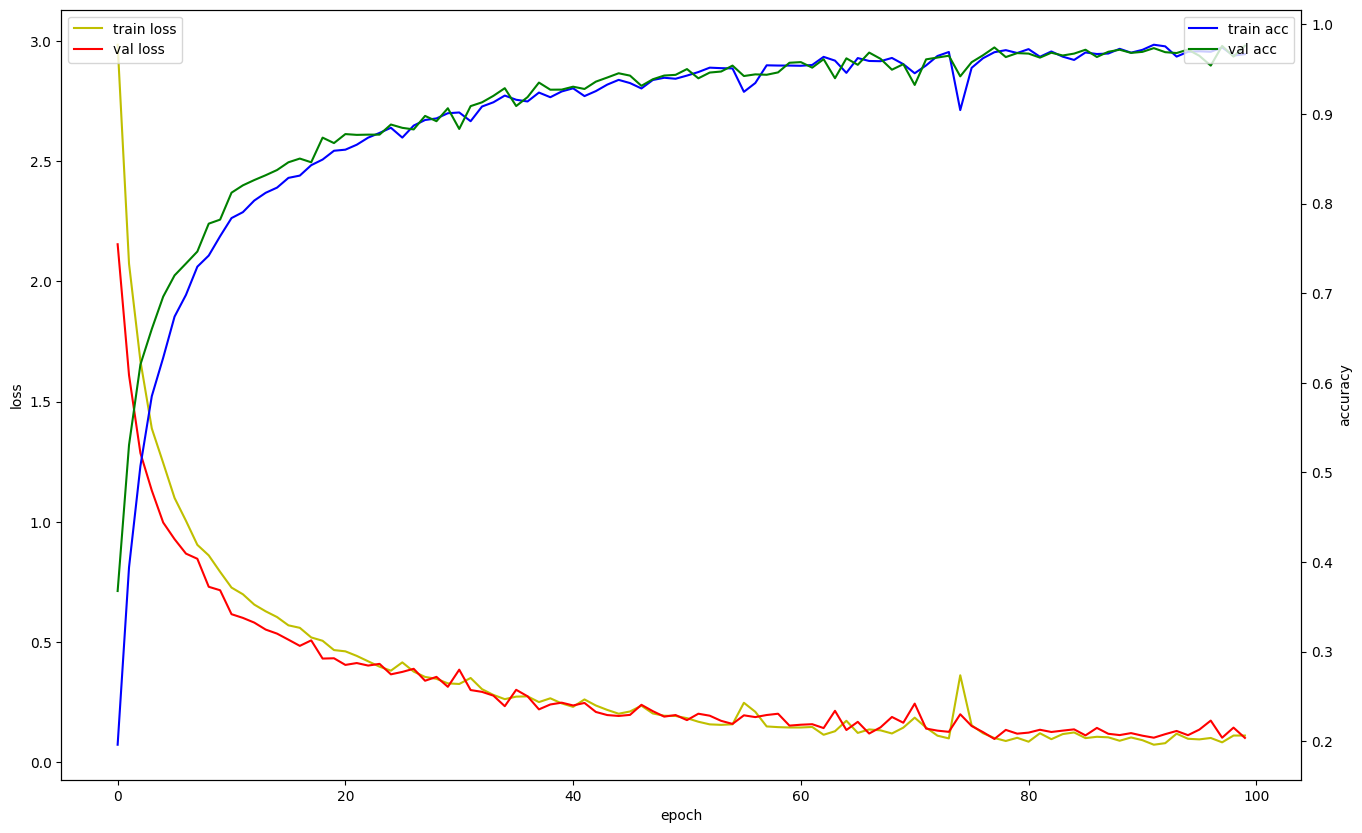

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [9]:
from keras.models import load_model

model = load_model('models/model.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 손실: {test_loss:.3f}")
print(f"테스트 정확도: {test_acc:.3f}")

355/355 [==============================] - 12s 24ms/step - loss: 0.1132 - acc: 0.9757
테스트 손실: 0.113
테스트 정확도: 0.976
